<a href="https://colab.research.google.com/github/hululuzhu/ml-alchemist-checklist/blob/main/ML_Alchemist_Checklist_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All-in-one checklist and code samples for practical ML alchemists
- Use MNIST as example to demo 30+ "ML alchemy" skills from `Training` and `Modeling` perspectives
- Contact: hululu.zhu@gmail.com
- Last update: V1.4, 03/24/2022


In [ ]:
# Make sure to use GPU to speed up the training
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-229f5c12-acc0-78f2-f0e4-d2dbe73c3b1f)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install -q tensorflow-addons
import tensorflow_addons as tfa
import tqdm.notebook as tqcolab
import numpy as np
import pandas as pd

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("x_train", x_train.shape, "\ty_train", y_train.shape)
print("x_test", x_test.shape, "\t\ty_test", y_test.shape)
summary_stats = {}

x_train (60000, 28, 28) 	y_train (60000, 10)
x_test (10000, 28, 28) 		y_test (10000, 10)


In [ ]:
# # @title # Visualize, enable if needed
# import matplotlib.pyplot as plt
# import random
# plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

# for i in range(9):
#     plt.subplot(3,3,i+1)
#     num = random.randint(0, len(x_train))
#     plt.imshow(x_train[num], cmap='gray', interpolation='none')
    
# plt.tight_layout()

In [ ]:
#@title # The core eval functions
def eval_model(build_model_fn,
               loss=keras.losses.CategoricalCrossentropy(from_logits=True),
               optimizer=tf.keras.optimizers.Adam(),
               batch_size=128,
               epochs=10,
               repeat_times=3, # so that we calculate mean/std to compare
               notes=None,
               verbose=0,
               callbacks=[],
               validation_data=None,
               class_weight=None,
               validation_split=None):
  accuracies = []
  for i in tqcolab.tqdm(range(repeat_times), ):
    model = build_model_fn()
    model.compile(loss=loss, optimizer=optimizer,
        metrics=[keras.metrics.CategoricalAccuracy()])  # fixed accuracy metric
    _ = model.fit(x=x_train, y=y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=verbose,
                  callbacks=callbacks,
                  validation_data=validation_data,
                  class_weight=class_weight,
                  validation_split=validation_split)
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    accuracies.append(accuracy)
  name = build_model_fn.__name__ if notes is None else notes
  summary_stats[name] = accuracies

def print_summary_by_notes(notes):
  print(f"{notes}: \t{round(np.mean(summary_stats[notes]), 3)}±"
        f"{round(np.std(summary_stats[notes]), 4)}")

def print_summary(build_model_fn):
  print_summary_by_notes(build_model_fn.__name__)

## Base Version of DNN

In [ ]:
def base_dnn():
  input = keras.Input(shape=(28, 28,))
  net = layers.Reshape(target_shape=(28 * 28,))(input)
  net = layers.Dense(units=128, activation="relu")(net)
  output_logits = layers.Dense(units=10)(net)
  return keras.Model(input, output_logits)

eval_model(base_dnn)
print_summary(base_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn: 	0.947±0.0021


# Group 1: Training "Skills"

## More or fewer epochs?

![pic for num of epochs](https://miro.medium.com/max/1400/1*GXftMdKjyaLYuAIn-nB4zA.png)

Reference: https://medium.com/@upendravijay2/what-is-epoch-and-how-to-choose-the-correct-number-of-epoch-d170656adaaf

In [ ]:
# @title # Too few epochs, often Underfitting
eval_model(base_dnn, epochs=5, notes="base_dnn_epoch5")
print_summary_by_notes('base_dnn_epoch5')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_epoch5: 	0.929±0.0061


In [ ]:
# @title # More epochs?
eval_model(base_dnn, epochs=20, notes="base_dnn_epoch20")
print_summary_by_notes('base_dnn_epoch20')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_epoch20: 	0.954±0.0013


## Learning Rate
![from stanford cs213n](https://cs231n.github.io/assets/nn3/learningrates.jpeg)

Reference https://cs231n.github.io/neural-networks-3/

In [ ]:
# @title # Smaller learning rate
# default adam leraning rate is 1e-3
eval_model(base_dnn,
           optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           notes="base_dnn_lr_1e-4")
print_summary_by_notes('base_dnn_lr_1e-4')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_lr_1e-4: 	0.942±0.0021


In [ ]:
# @title # Larger learning rate
eval_model(base_dnn,
           optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
           notes="base_dnn_lr_1e-2")
print_summary_by_notes('base_dnn_lr_1e-2')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_lr_1e-2: 	0.379±0.1497


In [ ]:
# @title # LR scheduler (cosine decay for example)
initial_learning_rate = 1e-3
decay_steps = 2000
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=0.99)
eval_model(base_dnn,
           optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
           notes="base_dnn_lr_cosine_decay")
print_summary_by_notes('base_dnn_lr_cosine_decay')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_lr_cosine_decay: 	0.947±0.0038


## Optimizers
![optimizer gif](https://miro.medium.com/max/1200/1*_osB82GKHBOT8k1idLqiqA.gif)

Reference https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6

### Vanilla SGD optimizer

![image](https://miro.medium.com/max/828/1*6a9Gx2UlB1ksh92TabyGPQ.png)
- θ is the weight parameter
- η is the learning rate and ∇J(θ;x,y) is the gradient of weight parameter θ

In [ ]:
# default adam uses 1e-3 learning rate
eval_model(base_dnn,
           optimizer=keras.optimizers.SGD(learning_rate=1e-3),
           notes="base_dnn_sgd")
print_summary_by_notes('base_dnn_sgd')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_sgd: 	0.914±0.0032


### Momentum

![image](https://miro.medium.com/max/994/1*dDB34j5iKVMSzjj6hEoGEw.png)
- Note Vt-1 and gamma to keep the "momentum" towards optimization direction

https://www.cs.toronto.edu/~fritz/absps/momentum.pdf

In [ ]:
eval_model(base_dnn,
           optimizer=keras.optimizers.RMSprop(learning_rate=1e-3,
                                              momentum=0.9),
           notes="base_dnn_momentum")
print_summary_by_notes('base_dnn_momentum')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_momentum: 	0.841±0.0196


### AdaGrad
![image](https://miro.medium.com/max/1400/1*SqryO8o7BP0f-LeU_5C8zw.png)

https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf

In [ ]:
eval_model(base_dnn,
           optimizer=keras.optimizers.Adagrad(learning_rate=1e-3),
           notes="base_dnn_adagrad")
print_summary_by_notes('base_dnn_adagrad')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_adagrad: 	0.908±0.0051


### RMSprop optimizer
![image](https://miro.medium.com/max/1400/1*adEDAdjulZUJisfzurVuWw.png)
- Adagrad learning rates diminish over time
- Usesing a moving average of the squared gradient

https://medium.datadriveninvestor.com/overview-of-different-optimizers-for-neural-networks-e0ed119440c3

In [ ]:
eval_model(base_dnn,
           optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
           notes="base_dnn_rmsprop")
print_summary_by_notes('base_dnn_rmsprop')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_rmsprop: 	0.957±0.0022


### Adam (Custom beta1/beta2)
![image](https://miro.medium.com/max/1400/1*zfdW5zAyQxge85gA_mFPYg.png)

https://arxiv.org/abs/1412.6980

In [ ]:
eval_model(base_dnn,
           optimizer=keras.optimizers.Adam(beta_1=0.99, beta_2=0.999),
           notes="base_dnn_adam_custom_beta")
print_summary_by_notes('base_dnn_adam_custom_beta')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_adam_custom_beta: 	0.942±0.004


### AdamW = Adam + Weight Decay

![image](https://miro.medium.com/max/1296/1*BOPnuP6VP0JVnJsoCdTo-g.png)

https://arxiv.org/abs/1711.05101

In [ ]:
eval_model(base_dnn,
           optimizer=tfa.optimizers.AdamW(weight_decay=0.01),
           notes="base_dnn_adamw")
print_summary_by_notes('base_dnn_adamw')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_adamw: 	0.941±0.0069


### LAMB
- Improved LARS (trust ratio) and ADAM, with more optimization to trust ratio
- See more https://arxiv.org/abs/1904.00962 (Training BERT in 76 minutes)
- and this article https://towardsdatascience.com/an-intuitive-understanding-of-the-lamb-optimizer-46f8c0ae4866

In [ ]:
eval_model(base_dnn,
           optimizer=tfa.optimizers.LAMB(learning_rate=1e-3),
           notes="base_dnn_lamb")
print_summary_by_notes('base_dnn_lamb')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_lamb: 	0.957±0.0016


### Sam (Sharpness-Aware Minimization) Optimizer
![](https://miro.medium.com/max/1280/1*3m8SyadmNivxbDWVXutVjg.png)

- https://arxiv.org/abs/2010.01412
- Reference: https://medium.com/@monadsblog/sharpness-aware-minimization-fcea0fd766d8

In [ ]:
# often useful for large vision transformation models
# Used https://github.com/Jannoshh/simple-sam implmentation
def sam_train_step(self, data, rho=0.05, eps=1e-12):
    # Unpack the data. Its structure depends on your model and
    # on what you pass to `fit()`.
    if len(data) == 3:
        x, y, sample_weight = data
    else:
        sample_weight = None
        x, y = data

    with tf.GradientTape() as tape:
        y_pred = self(x, training=True)  # Forward pass
        # Compute the loss value
        # (the loss function is configured in `compile()`)
        loss = self.compiled_loss(y, y_pred, sample_weight=sample_weight, regularization_losses=self.losses)

    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # first step
    e_ws = []
    grad_norm = tf.linalg.global_norm(gradients)
    ew_multiplier = rho / (grad_norm + eps)
    for i in range(len(trainable_vars)):
        e_w = tf.math.multiply(gradients[i], ew_multiplier)
        trainable_vars[i].assign_add(e_w)
        e_ws.append(e_w)

    with tf.GradientTape() as tape:
        y_pred = self(x, training=True)  # Forward pass
        # Compute the loss value
        # (the loss function is configured in `compile()`)
        loss = self.compiled_loss(y, y_pred, sample_weight=sample_weight, regularization_losses=self.losses)
        
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    for i in range(len(trainable_vars)):
        trainable_vars[i].assign_sub(e_ws[i])
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Update the metrics.
    # Metrics are configured in `compile()`.
    self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

    # Return a dict mapping metric names to current value.
    # Note that it will include the loss (tracked in self.metrics).
    return {m.name: m.result() for m in self.metrics}

class SamWrapperModel(tf.keras.Model):
    def train_step(self, data):
        return sam_train_step(self, data)

def sam_dnn():
  input = keras.Input(shape=(28, 28,))
  net = layers.Reshape(target_shape=(28 * 28,))(input)
  net = layers.Dense(units=128, activation="relu")(net)
  output_logits = layers.Dense(units=10)(net)
  return SamWrapperModel(input, output_logits)

eval_model(sam_dnn, epochs=20) # SAM takes "less-local-optimal" moves, so extending epochs needed
print_summary(sam_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

sam_dnn: 	0.927±0.0076


## Mini Batch Size

|--train loss--|--Test loss--|
|--------------|-------------|
|![train loss](https://miro.medium.com/max/759/1*Emk0bXNg_F-H74gg6T3L8Q.png)|![test](https://miro.medium.com/max/768/1*z5UEgD9eBRWa03uQLj9haA.png)|

Reference https://medium.com/deep-learning-experiments/effect-of-batch-size-on-neural-net-training-c5ae8516e57

In [ ]:
# @title ## Smaller batch size
eval_model(base_dnn,
           batch_size=32, 
           notes="base_dnn_batch_32")
print_summary_by_notes('base_dnn_batch_32')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_batch_32: 	0.944±0.0008


In [ ]:
# @title ## Larger batch size
eval_model(base_dnn,
           batch_size=512, 
           notes="base_dnn_batch_512")
print_summary_by_notes('base_dnn_batch_512')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_batch_512: 	0.928±0.0003


## Label Smooth

![ls example on train resnet](https://miro.medium.com/max/1050/1*7pOzVmsi6jPWReaFkHrqVQ.jpeg)

- Reference https://lessw.medium.com/label-smoothing-deep-learning-google-brain-explains-why-it-works-and-when-to-use-sota-tips-977733ef020

In [ ]:
# @title ## label_smoothing on CrossEntropy
eval_model(base_dnn,
           loss=keras.losses.CategoricalCrossentropy(from_logits=True,
                                                     label_smoothing=0.1), 
           notes="base_dnn_label_smooth")
print_summary_by_notes('base_dnn_label_smooth')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_label_smooth: 	0.926±0.0031


## Gradient Clipping
![screenshot](https://miro.medium.com/max/1050/1*vLFINWklJ0BtYtgzwK223g.png)

Reference https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

In [ ]:
# @title ## Clip graident by value
eval_model(base_dnn,
           optimizer=tf.keras.optimizers.Adam(clipvalue=1.0),
           notes="base_dnn_clip_gradient_value")
print_summary_by_notes('base_dnn_clip_gradient_value')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_clip_gradient_value: 	0.951±0.0012


In [ ]:
# @title ## Clip gradient by norm
eval_model(base_dnn,
           optimizer=tf.keras.optimizers.Adam(clipnorm=5), 
           notes="base_dnn_clip_gradient_norm")
print_summary_by_notes('base_dnn_clip_gradient_norm')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_clip_gradient_norm: 	0.95±0.0064


## Weight Decay (or L2 Regularization)
![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-27_at_8.15.13_PM_YGbJW74.png)

Reference https://paperswithcode.com/method/weight-decay

In [ ]:
# @title ## Weight decay on SGD
eval_model(base_dnn,
           optimizer=tfa.optimizers.SGDW(weight_decay=1e-3),
           notes="base_dnn_weight_decay")
print_summary_by_notes('base_dnn_weight_decay')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_weight_decay: 	0.957±0.0017


In [ ]:
# @title ## Adam+Weight Decay = Adamw
eval_model(base_dnn,
           optimizer=tfa.optimizers.AdamW(weight_decay=1e-2),
           notes="base_dnn_adamw2")
print_summary_by_notes('base_dnn_adamw2')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_adamw2: 	0.946±0.0039


## Earlystopping
![](https://miro.medium.com/max/948/1*wZg_RQHPRtn62dDp2Ez86A.jpeg)

Reference https://medium.com/ai%C2%B3-theory-practice-business/dropout-early-stopping-188a23beb2f9

In [ ]:
# @title ## Earlystop on training loss, and enable restore
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                               patience=3,
                                               restore_best_weights=True)
eval_model(base_dnn,
           notes="base_dnn_train_earlystop",
           epochs=20, # often give large epoch number when earlystop is applied
           callbacks=[es_callback])
print_summary_by_notes('base_dnn_train_earlystop')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_train_earlystop: 	0.953±0.0003


In [ ]:
# @title ## Earlystop on validation
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=3,
                                               restore_best_weights=True)
eval_model(base_dnn,
           notes="base_dnn_val_earlystop",
           epochs=20, # often give large epoch number when earlystop is applied
           callbacks=[es_callback],
           validation_split=0.1,)
print_summary_by_notes('base_dnn_val_earlystop')

  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_val_earlystop: 	0.949±0.0051


## Class Weights (for imbalance)
![](https://miro.medium.com/max/706/1*EIvMomyI_m4OGLvltQW1MA.png)

Reference https://medium.com/analytics-vidhya/handling-imbalanced-classes-3057a88e2a19

- Note we also often use [initial bias](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias) in our project
- see more at https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [ ]:
# @title ## Class_weights
# Other options include initial_weight_bias and sample_weights
(_, my_y_train), (_, _) = keras.datasets.mnist.load_data()
(unique, counts) = np.unique(my_y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
class_weights = {f[0]: f[1]/1e4 for f in frequencies}  # roughly normalize class weights
print("class_weights", class_weights)
eval_model(base_dnn,
           notes="base_dnn_class_weight",
           class_weight=class_weights)
print_summary_by_notes('base_dnn_class_weight')


class_weights {0: 0.5923, 1: 0.6742, 2: 0.5958, 3: 0.6131, 4: 0.5842, 5: 0.5421, 6: 0.5918, 7: 0.6265, 8: 0.5851, 9: 0.5949}


  0%|          | 0/3 [00:00<?, ?it/s]

base_dnn_class_weight: 	0.946±0.0019


# Group 2: Model "Skills"

## Feature Enginneer

In [ ]:
# @title ## Normalize pixel inputs
def normal_input_dnn():
  input = keras.Input(shape=(28, 28, ))
  net = layers.Reshape(target_shape=(28*28,))(input)
  # Instead of int, Scale to [0, 1]
  tf.cast(net, dtype=tf.float32)
  net = tf.math.scalar_mul(scalar=1./256, x=net)
  net = layers.Dense(128, activation="relu")(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(normal_input_dnn)
print_summary(normal_input_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

normal_input_dnn: 	0.979±0.0006


In [ ]:
# @title ## "Feature engineering": Add row/col means?
def feature_engineer_dnn():
  input = keras.Input(shape=(28, 28, ))
  flatten_net = layers.Reshape(target_shape=(28*28,))(input)
  # Mean of each row/column in a picture as "aggregated features"
  row_summary = tf.reduce_mean(input, axis=1)
  col_summary = tf.reduce_mean(input, axis=2)
  net = layers.Concatenate()([flatten_net, row_summary, col_summary])
  net = layers.Dense(128, activation="relu")(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(feature_engineer_dnn)
print_summary(feature_engineer_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

feature_engineer_dnn: 	0.944±0.0055


## Activation Functions

Reference https://medium.com/analytics-vidhya/activation-functions-all-you-need-to-know-355a850d025e

In [ ]:
# @title ## Use leaky relu
def leaky_relu_dnn():
  input = keras.Input(shape=(28, 28, ))
  net = layers.Reshape(target_shape=(28*28,))(input)
  net = layers.Dense(128, activation=layers.LeakyReLU())(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(leaky_relu_dnn)
print_summary(leaky_relu_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

leaky_relu_dnn: 	0.958±0.0029


In [ ]:
# @title ## Use gelu
def gelu_dnn():
  input = keras.Input(shape=(28, 28, ))
  net = layers.Reshape(target_shape=(28*28,))(input)
  net = layers.Dense(128, activation="gelu")(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(gelu_dnn)
print_summary(gelu_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

gelu_dnn: 	0.946±0.0023


In [ ]:
# @title ## Use tanh
def tanh_dnn():
  input = keras.Input(shape=(28, 28, ))
  net = layers.Reshape(target_shape=(28*28,))(input)
  net = layers.Dense(128, activation="tanh")(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(tanh_dnn)
print_summary(tanh_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

tanh_dnn: 	0.918±0.0057


## Weight Initialization

Reference https://medium.com/geekculture/weight-initialization-in-neural-nets-78091cfee93

In [ ]:
# @title ## Glorot (Xavier) Normal
# https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
def glorot_uniform_dnn():
  input = keras.Input(shape=(28, 28, ))
  net = layers.Reshape(target_shape=(28*28,))(input)
  # default GlorotNormal in base
  net = layers.Dense(128, activation="relu",
                     kernel_initializer="glorot_normal")(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(glorot_uniform_dnn)
print_summary(glorot_uniform_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

glorot_uniform_dnn: 	0.943±0.0027


In [ ]:
# @title ## He (Kaiming) Uniform
# https://arxiv.org/abs/1502.01852
def he_norm_dnn():
  input = keras.Input(shape=(28, 28, ))
  net = layers.Reshape(target_shape=(28*28,))(input)
  # default GlorotNormal in base
  net = layers.Dense(128, activation="relu",
                     kernel_initializer="he_uniform")(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(he_norm_dnn)
print_summary(he_norm_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

he_norm_dnn: 	0.945±0.0017


## DNN Width and Depth

In [ ]:
# @title ## Wider DNN (more neurons per layer)
def wider_dnn():
  input = keras.Input(shape=(28, 28, ))
  net = layers.Reshape(target_shape=(28*28,))(input)
  net = layers.Dense(768, activation="relu")(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(wider_dnn)
print_summary(wider_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

wider_dnn: 	0.956±0.0011


In [ ]:
# @title ## Deeper DNN (more layers thus deeper)
def deeper_dnn():
  input = keras.Input(shape=(28, 28, ))
  net = layers.Reshape(target_shape=(28*28,))(input)
  # 5 layers in the middle
  for _ in range(5):
    net = layers.Dense(128, activation="relu")(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(deeper_dnn)
print_summary(deeper_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

deeper_dnn: 	0.96±0.0025


## Network Regularization and Stabalization

Reference https://medium.com/ai-quest/regularization-techniques-a-list-down-70df0e8693c

In [ ]:
# @title ## Dropout (add regularization)
def dropout_dnn():
  input = keras.Input(shape=(28, 28, ))
  net = layers.Reshape(target_shape=(28*28,))(input)
  net = layers.Dropout(rate=0.1)(net)
  net = layers.Dense(128, activation="relu")(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(dropout_dnn)
print_summary(dropout_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

dropout_dnn: 	0.946±0.0021


In [ ]:
# @title ## Batch Normalization
def batch_norm_dnn():
  input = keras.Input(shape=(28, 28, ))
  net = layers.Reshape(target_shape=(28*28,))(input)
  net = keras.layers.BatchNormalization()(net)
  net = layers.Dense(128, activation="relu")(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(batch_norm_dnn)
print_summary(batch_norm_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

batch_norm_dnn: 	0.975±0.0002


In [ ]:
# @title ## Layer Normalization
# Note some people think layer norm is not regularization
def layer_norm_dnn():
  input = keras.Input(shape=(28, 28, ))
  net = layers.Reshape(target_shape=(28*28,))(input)
  net = keras.layers.LayerNormalization()(net)
  net = layers.Dense(128, activation="relu")(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(layer_norm_dnn)
print_summary(layer_norm_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

layer_norm_dnn: 	0.978±0.0014


## Powerful NN Components (cnn/rnn)

In [ ]:
# @title ## Convolutional Neural Network (CNN)
# https://en.wikipedia.org/wiki/Convolutional_neural_network
def cnn_dnn():
  input = keras.Input(shape=(28, 28, ))
  input = tf.expand_dims(input, axis=-1)  # CNN expects a channel dimension
  cnn_kernels = [32, 64, 128]
  for i in range(len(cnn_kernels)):
    net = layers.Conv2D(cnn_kernels[i], kernel_size=(3, 3), activation="relu")(
        input)
    net = layers.MaxPooling2D(pool_size=(2, 2))(net)
  net = layers.Flatten()(net)
  net = layers.Dropout(0.5)(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(cnn_dnn)
print_summary(cnn_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

cnn_dnn: 	0.979±0.0021


In [ ]:
# @title ## Long Short term Memory (LSTM/RNN)
# https://en.wikipedia.org/wiki/Recurrent_neural_network
def lstm_dnn():
  input = keras.Input(shape=(28, 28, ))
  net = layers.LSTM(units=128)(input)
  net = layers.Flatten()(net)
  net = layers.Dropout(0.5)(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(lstm_dnn)
print_summary(lstm_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

lstm_dnn: 	0.93±0.0045


## Pretrained Models

In [ ]:
# @title ## Pretrained Resnet50
# see https://arxiv.org/abs/1512.03385
def resnet_dnn():
  input = keras.Input(shape=(28, 28,))
  # Create 3 channels (RGB) from grayscale by assigning same value
  net = tf.stack([input] * 3, axis = -1)
  resnet_model = keras.applications.ResNet50V2(
      include_top=False, pooling='avg'
  )
  net = resnet_model(net)
  output_logits = layers.Dense(10)(net)
  model = keras.Model(input, output_logits)
  # Freeze resnet based on keras guide, but language models often do not freeze
  model.layers[-2].trainable = False
  return model

eval_model(resnet_dnn)
print_summary(resnet_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

94683136/94668760 [==============================] - 1s 0us/step
resnet_dnn: 	0.904±0.004


## Model Calibration

In [ ]:
# @title ## ------TODO Model calibration
# Probably hard to see improvements for MNIST

# Combine a "best" model?

In [ ]:
#@title # Combine "tricks" together to try 99% test accuracy, and I did it!
# Normal input + CNN + layernorm + dropout + deeper + moreepochs + rmsprop + earlystop...
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                               patience=3,
                                               restore_best_weights=True)
def best_rc_dnn():
  input = keras.Input(shape=(28, 28, ))
  # Instead of int, Scale to [0, 1]
  tf.cast(input, dtype=tf.float32)
  input = tf.math.scalar_mul(scalar=1./256, x=input)
  input = tf.expand_dims(input, axis=-1)  # CNN expects a channel dimension
  cnn_kernels = [32, 64, 128]
  for i in range(len(cnn_kernels)):
    net = layers.Conv2D(cnn_kernels[i], kernel_size=(3, 3), activation="relu")(
        input)
    net = layers.Dropout(rate=0.25)(net)
    net = layers.MaxPooling2D(pool_size=(2, 2))(net)
  net = layers.Flatten()(net)
  net = keras.layers.LayerNormalization()(net) 
  net = layers.Dropout(rate=0.25)(net)
  net = layers.Dense(128, activation='relu')(net)
  net = keras.layers.LayerNormalization()(net) 
  net = layers.Dropout(rate=0.25)(net)
  net = layers.Dense(256, activation='relu')(net)
  net = keras.layers.LayerNormalization()(net) 
  net = layers.Dropout(rate=0.25)(net)
  output_logits = layers.Dense(10)(net)
  return keras.Model(input, output_logits)

eval_model(best_rc_dnn,
           notes="best_rc_dnn",
           epochs=30,
           optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
           callbacks=[es_callback])
print_summary(best_rc_dnn)

  0%|          | 0/3 [00:00<?, ?it/s]

best_rc_dnn: 	0.99±0.0002


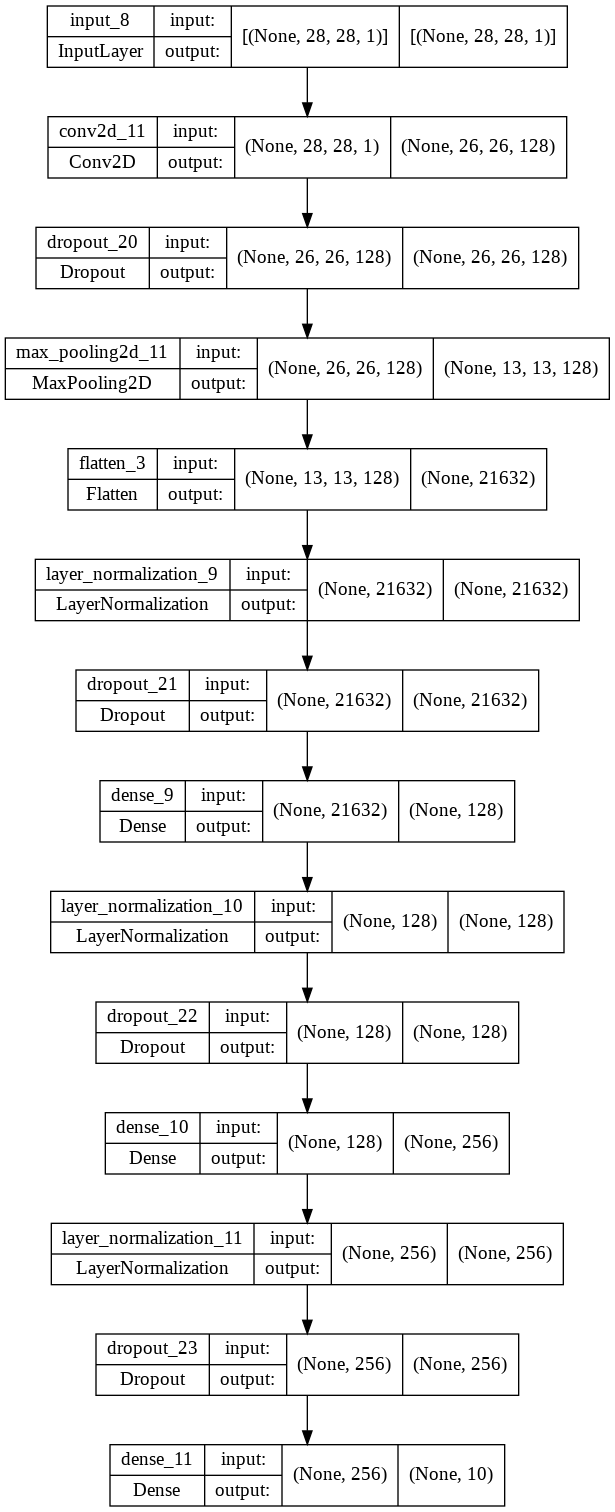

In [ ]:
#@title # Visualize the model
tf.keras.utils.plot_model(
    best_rc_dnn(), to_file='/tmp/model_1.png', show_shapes=True)

# Summary

In [ ]:
format_results = []
for k in summary_stats:
  # print_summary_by_notes(k)
  format_results.append({
      'key': k,
      'mean': np.mean(summary_stats[k]),
      'std': np.std(summary_stats[k]),
  })
result_pd = pd.DataFrame(format_results)
result_pd.sort_values(by='mean', ascending=False)

,key,mean,std
39,best_rc_dnn,0.990100,0.000245
24,normal_input_dnn,0.978833,0.000613
36,cnn_dnn,0.978800,0.002112
35,layer_norm_dnn,0.978400,0.001445
34,batch_norm_dnn,0.974800,0.000216
32,deeper_dnn,0.959900,0.002539
26,leaky_relu_dnn,0.958233,0.002899
19,base_dnn_weight_decay,0.957433,0.001717
7,base_dnn_rmsprop,0.956800,0.002246
12,base_dnn_lamb,0.956633,0.001586
